<a href="https://colab.research.google.com/github/Lynnluxu/style-transfer/blob/master/Neural_Style_Transfer_Lille_images_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer with Lille images using Pytorch**
---






## **Mount google drive firstly**
---

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Install requirements**
---

In [31]:
!pip install -r "/content/drive/My Drive/resources/requirements.txt"

  Cloning https://github.com/bleshik/instaloader.git to /tmp/pip-req-build-qhkibsok
  Running command git clone -q https://github.com/bleshik/instaloader.git /tmp/pip-req-build-qhkibsok
  Created wheel for instaloader: filename=instaloader-4.2.6-cp36-none-any.whl size=41606 sha256=caf1a3e732b631b6820cee5eeca2ea363101b76d3b5d397c689d0452ac9c40ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jaj07i2/wheels/6b/99/f9/f37a7414fbe8f3b65e10fff1997066aa80618578a9e0ba3687
Successfully built instaloader


## **Import libraries**
---

In [0]:
# import resources
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np

from instaloader import Instaloader, Profile
from fastai.vision import *
from pathlib import Path
import itertools

import torch
import torch.optim as optim
from torchvision import *
import torch.nn.functional as F

from PIL import Image


## **Download Lille images (content)**









In [0]:
# Get current directory
content_path = Path('drive/My Drive/data/content/')
content_folder = "dataset_lille_images"
txt_file_name = "lille_images_urls.txt"

# Create the directories to store the images
os.makedirs(content_path/content_folder, exist_ok=True)

Get URLs images of instagram posts using instaloader library and write them into a txt file

In [0]:
loader = Instaloader(download_videos=False,
                 download_video_thumbnails=False,
                 download_geotags=False,
                 download_comments=False,
                 save_metadata=False,
                 compress_json=False,)

profile_name = "lillemaville"
profile = Profile.from_username(loader.context, profile_name)

In [0]:
NB_IMAGES_TO_DOWNLOAD = 50
file = open(content_path/txt_file_name, 'w')

for post in itertools.islice(profile.get_posts(), NB_IMAGES_TO_DOWNLOAD):
    file.write("%s\n" % post.url)
    
file.close()

Download the retrieved images with Fastai

In [36]:
path_content_imgs = content_path/content_folder

print("Downloading Lille Images...")
download_images(urls=content_path/txt_file_name, dest=path_content_imgs)

# verify images have correct properties for training
print("Delete Corrupted Images...")
verify_images(path_content_imgs, delete=True, img_format=f'{content_folder} %d')

Delete Corrupted Images...


## **Data exploration** - Looking at the data...
---

In [0]:
#TODO : Data visualisation of Lille images

In [0]:
fnames = get_image_files(path_content_imgs)

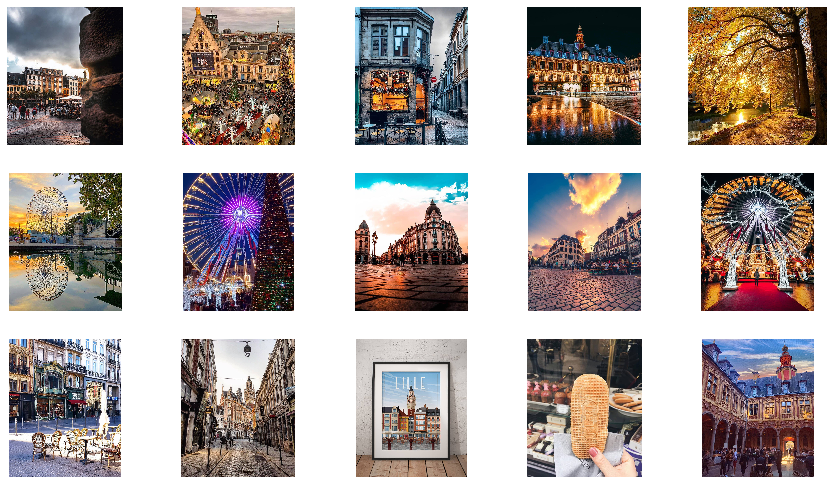

In [39]:
plt.figure(figsize=(15,30))

for i in range(15):
    plt.subplot(10,5,i+1)
    plt.axis('off')
    data = plt.imread(fnames[i])
    plt.imshow(data)


## **Create Dataset and Data Loader**
---

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

transform = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor(), # transform it into a torch tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Lambda(lambda x: x[:3,:,:].unsqueeze(0))
    ])  

content_data = datasets.ImageFolder("/content/drive/My Drive/data/content", transform=transform)

In [41]:
dataloader = DataLoader(content_data, batch_size=4, shuffle=True)
print(f"Number of Lille images: {len(dataloader.dataset)}")

Number of Lille images: 50


In [42]:
content_data[0][0].shape

torch.Size([1, 3, 631, 512])

## **Helpers functions for images**
---

In [0]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## **Importing the model** (test VGG16)
---

In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#resnet vgg16
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # Load VGG Skeleton (only convolutional and pooling layers)
        self.features = models.vgg16(pretrained=True).features

        # Freeze all VGG parameters
        for param in self.features.parameters():
            param.requires_grad = False
        
        # weights for each style layer 
        # weighting earlier layers more will result in *larger* style artifacts
        self.style_layers_weights = {'conv1_1': 1.,
                        'conv2_1': 0.75,
                        'conv3_1': 0.2,
                        'conv4_1': 0.2,
                        'conv5_1': 0.2}

        self.content_layer = 'conv4_2'

    def forward(self, x):
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', ## content representation
                  '28': 'conv5_1'}

        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x

        return features

In [0]:
# style = load_image("/content/drive/My Drive/data/style/starrynight.jpg")
# model = VGG19()
# style_features = model(style)

## **Gram matrix**
---

In [0]:
def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    bs, d, h, w = tensor.size()
   
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(bs * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram

## **Weights for style transfer**
---

In [0]:
content_weight = 1  # alpha
style_weight = 1e9  # beta
sw = "%e" %(style_weight)

## **Making style transfer**
---

In [0]:
model = VGG16().to(device)

In [0]:
# load in content and style image
content_img_path = str(fnames[4])
content = load_image(content_img_path).to(device)

# Resize style to match content, makes code easier
style_img_path = 'drive/My Drive/data/style/wave.png'
style = load_image(style_img_path, shape=content.shape[-2:]).to(device)

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
# iteration hyperparameters
mse_loss = nn.MSELoss()
optimizer = optim.Adam([target], lr=0.003)
EPOCHS = 2000  
show_every = 400

In [0]:
content_features = model(content)
style_features = model(style)
# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

Total loss:  514231369728.0


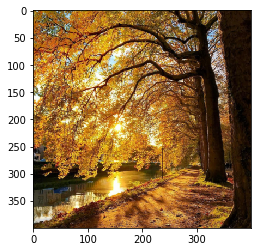

Total loss:  60830789632.0


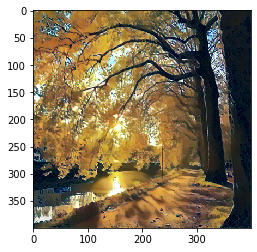

Total loss:  30782578688.0


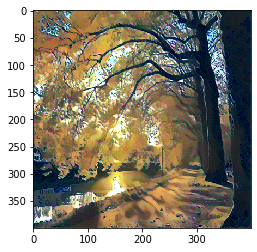

Total loss:  21923708928.0


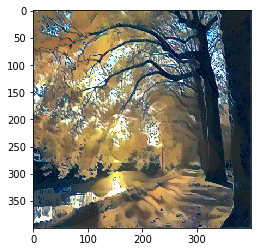

Total loss:  16798829568.0


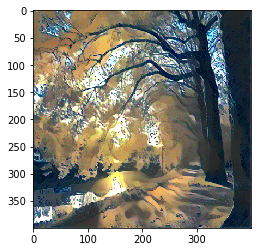

CPU times: user 59.4 s, sys: 47.2 s, total: 1min 46s
Wall time: 1min 47s


In [67]:
%%time 
for i in range(EPOCHS):
    # get the features from your target image
    target_features = model(target)

    # the content loss
    content_loss = mse_loss(target_features[model.content_layer], content_features[model.content_layer])
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0.0

    # then add to it for each layer's gram matrix loss
    for layer in model.style_layers_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        bs, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # the style loss for one layer, weighted appropriately
        layer_style_loss = model.style_layers_weights[layer] * mse_loss(target_gram, style_gram)
        # add to the style loss
        style_loss += layer_style_loss / (bs * d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

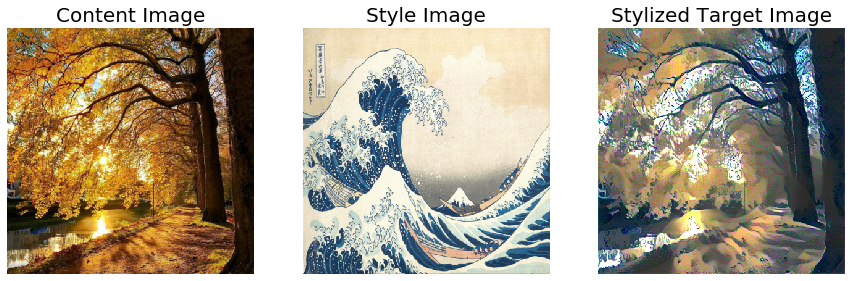

In [68]:
 # display content and final, target image
fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax3.imshow(im_convert(style))
ax3.set_title("Style Image", fontsize = 20)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

### **Save the stylized target image**
---

In [0]:
results_path = Path('drive/My Drive/data/results/')

# Create the directories to store the images
os.makedirs(results_path, exist_ok=True)

In [0]:
style_fname = os.path.basename(style_img_path).split(".")[0]
content_fname = os.path.basename(content_img_path).split(".")[0]
target_fname = f"{style_fname}_{content_fname}_{content_weight}_{sw}_vgg16"

plt.imsave(f"{results_path}/{target_fname}.jpg", im_convert(target), dpi = 800)